In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps

from phaseunwrapping import upsampling_matrix, wrap_function, build_1d_first_order_grad, build_2d_first_order_grad

# Toy problem

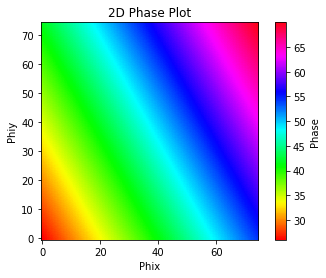

In [28]:
# create phase date for x and y direction
M = 75
N = 75
phix = np.linspace(0, 9*np.pi, M) + (3*np.pi) + 3
phiy = np.linspace(0, 5*np.pi, N) + (4*np.pi) + 1
X, Y = np.meshgrid(phix, phiy)
phi = X + Y

# Create the phase plot (source Chat GPT for the below code)
plt.imshow(phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Phase Plot')
plt.show()

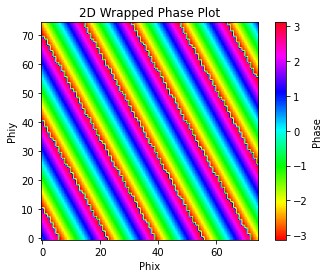

In [29]:
psi = wrap_function(phi)
plt.imshow(psi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Wrapped Phase Plot')
plt.show()


# Banded cholesky

In [30]:
import scipy.sparse as scipy_sparse
from scipy.sparse import linalg as scipy_splinalg

In [31]:
def banded_cholesky_factor(A, check=False):
    """
    Given a sparse banded matrix (SciPy or CuPy) :math:`A`, returns the Cholesky factor :math:`L` in the factorizations
    :math:`A = L L^T` with :math:`L` lower-triangular. Here :math:`A` must be a positive definite matrix.
    """
    
    # # Determine CPU or GPU
    # if CUPY_INSTALLED:
    #     xp = cp.get_array_module(A)
    #     if xp == cp:
    #         sp = cupy_sparse
    #         splinalg = cupy_splinalg
    #     else:
    #         sp = scipy_sparse
    #         splinalg = scipy_splinalg
    # else:
    #     xp = np
    #     sp = scipy_sparse
    #     splinalg = scipy_splinalg

    xp = np
    sp = scipy_sparse
    splinalg = scipy_splinalg
    
    # Shape
    n = A.shape[0]
    
    # Sparse LU
    LU = splinalg.splu(A, diag_pivot_thresh=0, permc_spec="NATURAL") 

    # Check for positive-definiteness
    posdef_check = ( LU.perm_r == xp.arange(n) ).all() and ( LU.U.diagonal() > 0 ).all()
    assert posdef_check, "Matrix not positive definite!"
    
    # Extract factor
    L = LU.L.dot( sp.diags(LU.U.diagonal()**0.5) )
    
    # Check?
    if check:
        guess = L @ L.T
        norm_error = xp.linalg.norm( guess.toarray() - A.toarray() )
        print(f"L2 norm between L L^T and A: {norm_error}")
    
    return L, LU


# Upsampling matrix

In [32]:
from scipy.sparse import csc_matrix

In [33]:
def upsampling_matrix(n, sparse=False):
    """Constructing the upsampling matrix.
    """

    if not sparse:
        P = np.zeros((n+1, n))
        P[1:, :] = np.eye(n)
        return P
    else:
        P = csc_matrix((n+1,n))
        P.setdiag(1,k=-1)
        return P

        

In [34]:
upsampling_matrix(3, sparse=False)

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [35]:
upsampling_matrix(3, sparse=True).toarray()

/Users/jonathanlindbloom/opt/miniconda3/envs/speckle38/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

# With cholesky

In [44]:
# Get flattened version of psi
psi_flatten = psi.flatten()

# Gradient ops
Fx, Fy = build_2d_first_order_grad(M,N, boundary="none")

# Weights
weights = np.ones(Fx.shape[0])

P = upsampling_matrix(len(psi_flatten) - 1, sparse=True)

phi1 = np.zeros(len(psi_flatten))
phi1[0] = psi_flatten[0]

Dweights = sps.diags(weights)

# rhs vector
rhs = P.T @ Fx.T @ Dweights @ ( wrap_function(Fx @ psi_flatten) - (Fx @ phi1) ) + P.T @ Fy.T @ Dweights @ ( wrap_function(Fy @ psi_flatten) - (Fy @ phi1) )

# Q matrix
Q = P.T @ Fx.T @ np.diag(weights) @ Fx @ P  + P.T @ Fy.T @ np.diag(weights) @ Fy @ P

# banded cholesky
L, superlu = banded_cholesky_factor(Q)

# Compute mean
sol = superlu.solve(rhs)

# Include initial phase value
reconstructed_phi = np.zeros(len(psi_flatten))
reconstructed_phi[1:] = sol
reconstructed_phi[0] = psi_flatten[0]
reconstructed_phi = reconstructed_phi.reshape((M,N))

/Users/jonathanlindbloom/opt/miniconda3/envs/speckle38/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/jonathanlindbloom/opt/miniconda3/envs/speckle38/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


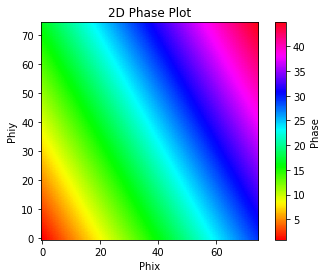

In [45]:
# # create phase date for x and y direction
# M = 75
# N = 75
# phix = np.linspace(0, 9*np.pi, M) + (3*np.pi) + 3
# phiy = np.linspace(0, 5*np.pi, N) + (4*np.pi) + 1
# X, Y = np.meshgrid(phix, phiy)
# phi = X + Y

# Create the phase plot (source Chat GPT for the below code)
plt.imshow(reconstructed_phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Phase Plot')
plt.show()

# Function

In [ ]:
def mle_2d_banded_cholesky(psi, weights=None):
    """
    """
    M, N = psi.shape

    # Get flattened version of psi
    psi_flatten = psi.flatten()

    # Gradient ops
    Fx, Fy = build_2d_first_order_grad(M,N, boundary="none")

    if weights is None:
        weights = np.ones_like(psi)
    else:
        assert len(weights) == len(psi), "psi and weight vector must have same length!"
    weights = weights.flatten()

    P = upsampling_matrix(len(psi_flatten) - 1, sparse=True)

    phi1 = np.zeros(len(psi_flatten))
    phi1[0] = psi_flatten[0]

    Dweights = sps.diags(weights)

    # rhs vector
    rhs = P.T @ Fx.T @ Dweights @ ( wrap_function(Fx @ psi_flatten) - (Fx @ phi1) ) + P.T @ Fy.T @ Dweights @ ( wrap_function(Fy @ psi_flatten) - (Fy @ phi1) )

    # Q matrix
    Q = P.T @ Fx.T @ np.diag(weights) @ Fx @ P  + P.T @ Fy.T @ np.diag(weights) @ Fy @ P

    # banded cholesky
    L, superlu = banded_cholesky_factor(Q)

    # Compute mean
    sol = superlu.solve(rhs)

    # Include initial phase value
    reconstructed_phi = np.zeros(len(psi_flatten))
    reconstructed_phi[1:] = sol
    reconstructed_phi[0] = psi_flatten[0]
    reconstructed_phi = reconstructed_phi.reshape((M,N))

    return reconstructed_phi

    